# 2. 앙상블 모델 적용

<u>의사결정 트리의 가장 큰 문제점은 훈련데이터에 대한 적합이 심하다. ➡️ 고분산성을 갖음 </u>

앙상블은 성능이 좋지 않은 알고리즘들을 결합시켜 종합한 결과 더 좋게 만드는 것 <br>
(대표적인 케이스로 Bagging(Bootstrap Aggregating))

* 부트스트랩 : bootstrap. 중복을 허용하는 리샘플링
* 배깅 : Bagging. Bootstrap aggregating의 약자.
* 훈련 데이터에서 BootStrapping한 샘플에 대해 `모든 변수를 선택해 다수의 의사결정 트리를 구성`
(의사결정 트리의 분할을 위해 선택된 변수가 모든 트리에서 대체로 비슷해져 상관관계를 가지면 종합을 한다 해도 분산 감소 효과가 기대만큼 크지 않을 수 있음)
* 하나의 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 할 수 있음
* 동시에 CPU의 멀티 코어나 병렬 프로세서에서 학습을 진행하는 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦
* 개별 예측기의 편향은 높지만, 수집함수를 통과한 후 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때보다 편향은 비슷하지만 대체로 분산은 줄어듦.


## 앙상블 학습과 랜덤 포레스트

* 랜덤 포레스트는 `특징 기반 배깅 방법`을 적용한 의사결정 트리의 앙상블
* 트리 배깅은 의사결정 트리의 단점 중 하나인 고분산을 줄여주며 이를 통해 단일 트리보다 훨씬 더 좋은 성능을 제공함
* 개별 트리간의 상관관계 문제를 피하기 위해 bootstrapping 과정에서 훈련 데이터로부터 전체 p개의 변수 중 무작위 m개의 변수만 선택 <br>
분류기 문제 : m = sqrt(p) <br>
회귀 문제 : m = p/3 <br>
* 랜덤 포레스트의 무작위성 주입은 트리를 보다 다양하게 만들고, 편향을 손해 보는 대신 분산을 낮추어 훌륭한 모델을 만듦

## 랜덤 포레스트의 특징 중요도

* 의사결정 트리를 기반으로 하는 모델이므로 특징의 상대적 중요도를 측정하기 쉬운 장점을 지님
* 무작위성이 주입된 랜덤포레스트 모델은 의사결정 트리와 달리 모든 특징에 대해 중요도를 측정함
* 랜덤 포레스트의 특정 중요도는 각 의사결정 트리의 특징 중요도를 모두 합한 후 트리의 수로 나눈것으로, scikit-learn의 경우 중요도의 합이 1이 되도록 결과값을 정규화함

## 데이터 준비

In [21]:
import pandas as pd

train_df = pd.read_csv('train', nrows=100000)  
unused_columns, label_column = ['id', 'hour', 'device_id', 'device_ip'], 'click' # 사용하지 않을 Columns, label Column 지정

# 훈련용 데이터 생성
train_df = train_df.drop(unused_columns, axis=1)
X_dict_train = list(train_df.drop(label_column, axis=1).T.to_dict().values()) # 특징행렬을 만들기 전에, df->dictionary 형태로 바꾸어 그 안의 values만 추출
X_dict_train[0] # 
y_train = train_df[label_column] # 대상벡터

In [22]:
# 평가용 데이터 생성
test_df = pd.read_csv('train', header=0, skiprows=(1, 100000), nrows=100000) # 1 ~ 100,000행은 앞서 읽어왔기 때문에 그 부분을 skip.
test_df = test_df.drop(unused_columns, axis=1)
X_dict_test = list(test_df.drop(label_column, axis=1).T.to_dict().values())
y_test = test_df[label_column]

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()

In [24]:
from sklearn.feature_extraction import DictVectorizer

# vectorizing할 때, 이진 변환하니까 0이 무수히 많이 생긴다.
# 0이 무수히 많아지면 메모리 낭비가 심해지기 때문에, 희소 행렬 형태로 작업해야 메모리 문제를 해결할 수 있다.
vectorizer = DictVectorizer(sparse=True) 

# 훈련용 데이터에 대해 One-Hot Encoding 벡터 변환
X_train = vectorizer.fit_transform(X_dict_train)
X_train.shape  # 19차원에서 4952차원으로 늘어남. (범주형 데이터를 이진 변환했기 때문)

(100000, 4952)

In [25]:
X_train.toarray()[:5] # 희소행렬이 아닌 정상적인 행렬 형태로 다시 변환.

array([[ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 18993.,   320., ...,     0.,     0.,     0.]])

In [26]:
# 평가용 데이터에 대해서도 One-Hot Encoding 벡터 변환
X_test = vectorizer.fit_transform(X_dict_test) 
X_train.toarray()[:5]

array([[ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 18993.,   320., ...,     0.,     0.,     0.]])

In [27]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=500, n_jobs=-1) # 
random_forest.fit(iris.data, iris.target)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [28]:
for feature, importance in zip(iris.feature_names, random_forest.feature_importances_) :
    print("{} : {}" .format(feature, importance))

# 배제된 것 없이 모두 중요도를 확인할 수 있음

sepal length (cm) : 0.10898253791505605
sepal width (cm) : 0.025889077035344356
petal length (cm) : 0.42697727016595854
petal width (cm) : 0.4381511148836409


## 특징 기반 배깅을 이용하여 트리 배깅 모델 랜덤포레스트의 학습

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [30]:
random_forest = RandomForestClassifier(
    n_estimators=100, criterion='gini', \
    min_samples_split=30, n_jobs=-1
)

In [31]:
parameters = {'max_depth' : [3, 10, None]}
grid_search = GridSearchCV(random_forest, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

In [32]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(min_samples_split=30, n_jobs=-1),
             n_jobs=-1, param_grid={'max_depth': [3, 10, None]},
             scoring='roc_auc')

## 랜덤 포레스트의 성능 개선을 위한 주요 parameter

* max_features : 최적의 분할 지점을 찾기 위해 검토할 특징의 개수. 일반적으로 n차원의 데이터셋의 $\sqrt{n}$의 반올림 값을 설정
* n_estimators : 트리의 개수가 많을수록 성능이 더 좋지만 계산 시간이 많이 걸림. 일반적으로 100, 200, 500을 설정
* min_sample_splits : 노드에서 추가 분할을 위해 필요한 샘플의 최소 개수. 숫자가 너무 작으면 오버피팅, 너무 크면 언더피팅이 일어날 수 있음. 일반적으로 10, 30, 50으로 시작

## 랜덤 포레스트 모델의 성능 측정 : 정확도, 혼동행렬, ROC의 AUC

In [33]:
grid_search.best_params_

{'max_depth': None}

In [34]:
random_forest_best = grid_search.best_estimator_

In [35]:
y_pred = random_forest_best.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [38]:
accuracy_score(y_test, y_pred)

0.85182

In [39]:
confusion_matrix(y_test, y_pred)

array([[81311,  1199],
       [13619,  3871]])

In [40]:
y_pred_proba = random_forest_best.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.20763688, 0.13601532, 0.3057977 , ..., 0.11713055, 0.17314492,
       0.04912028])

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [42]:
auc = roc_auc_score(y_test, y_pred_proba)

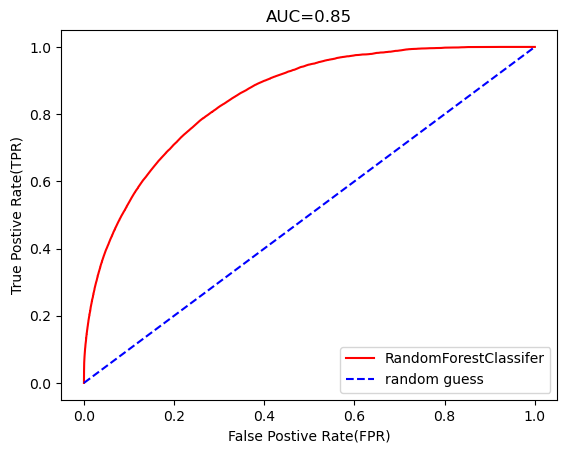

In [43]:
import matplotlib.pyplot as plt 

plt.plot(fpr, tpr, 'r-', label='RandomForestClassifer')
plt.plot([0, 1], [0, 1], 'b--', label='random guess')
plt.xlabel('False Postive Rate(FPR)')
plt.ylabel('True Postive Rate(TPR)')
plt.title("AUC={0:.2f}" .format(auc))
plt.legend(loc='lower right')

# 의사결정트리 모델의 경우 AUC = 0.72 였었다.
# RandomForestClassifer는 의사결정트리 모델보다 더 좋은 성능을 제공해준다.